In [1]:
import pandas as pd
import numpy  as np

import pickle
 
from pathlib import Path

import matplotlib.pyplot as plt

from scipy.stats import  mannwhitneyu, ks_2samp


pd.set_option('display.max_columns', 5)

In [2]:
#### user specified

data_folder = "D:/analyze_Pearson_residuals/"

data_subfolder = "33k_PBMC"

data_path = Path ( data_folder + data_subfolder )


import sys
sys.path.append( data_folder )

from  plot_tab_utilities import *

In [3]:
# output plots
Ag_plot_jpg = data_subfolder + "_Figure_2.jpg"
Lg_plot_jpg = data_subfolder + "_Figure_4.jpg"  
Sg_plot_jpg = data_subfolder + "_Figure_6.jpg"

# input data
nru_dict_pkl =  "nru_dict.pkl"
scanpy_variance_pkl = "residual_variance_scanpy.pkl"
SCT_variance_pkl = "SCT_v2_residual_variance.pkl"
Ag_complementary_pkl = "Ag_complementary_samples.pkl"
Lg_complementary_pkl = "Lg_complementary_samples.pkl"
Sg_complementary_pkl = "Sg_complementary_samples.pkl"
 
genes_tsv  = "genes.tsv" 
# genes_tsv  = "features.tsv" 


# paths: output plots
Ag_plot_dsn = data_path / Ag_plot_jpg
Lg_plot_dsn = data_path / Lg_plot_jpg
Sg_plot_dsn = data_path / Sg_plot_jpg

# paths: input data
nru_dict_dsn = data_path / nru_dict_pkl
scanpy_variance_dsn = data_path / scanpy_variance_pkl
SCT_variance_dsn = data_path / SCT_variance_pkl
Ag_complementary_dsn = data_path / Ag_complementary_pkl
Lg_complementary_dsn = data_path / Lg_complementary_pkl
Sg_complementary_dsn = data_path / Sg_complementary_pkl


# tsv input 
genes_dsn = data_path / genes_tsv

In [4]:
def plot_tab ( df_analy, method_symbol, method_label, plot_jpg_dsn, notate=False ):

  df_analy['ratio'] = df_analy[1]/ df_analy[0]
  df_analy['abs_log_ratio'] = np.abs ( np.log10 ( df_analy['ratio'] ) ) 

  df_analy['rank_0'] = df_analy[0].rank ( ascending=False )
  df_analy['rank_1'] = df_analy[1].rank ( ascending=False )

  df_analy['group_0'] = pd.cut ( df_analy['rank_0'], bins, labels=labels )
  df_analy['group_1']   = pd.cut ( df_analy['rank_1'], bins, labels=labels )
 
  xtab_in = df_analy.rename( columns={'group_0':'S', 'group_1':'S_tilde'} )
  pt_S_v_S_tilde = pv_table_noprint_margins ( xtab_in, 'S', 'S_tilde' )


  df_top_2K = df_analy[ df_analy['rank_stat'] <= 2000 ]     
    
    
  rank_stat_200 = df_analy['stat'].loc [ df_analy['rank_stat'] <= 200 ].min()  
  print (  '\n\n genes rank_stat_200: ', rank_stat_200 )  

 
  fig, (ax1, ax2, ax3 )  = plt.subplots(1,3, figsize=( 8., 3. ) )

  plot_ax ( df_analy, ax1, 'A', 0, 1, 'sample S', 'sample $\~S$'  )
    
  plot_ax ( df_analy, ax2, 'B', 'stat', 'abs_log_ratio', method_label,  method_symbol.lower()  + ': instability' , yscale_log=False, line_slope='none' )
  ax2.axvline ( rank_stat_200,  linewidth=1, color='red') 

  plot_ax ( df_top_2K, ax3, 'C', 'nz_cells', 'abs_log_ratio',  "$n_g$: nonzero cells" , method_symbol.lower()  + ': instability' ,yscale_log=False, line_slope='none' )
  

  if  notate:
    df_annotation_gene_plot_data = df_analy.loc [ df_analy ['gene_symbol'].isin ( list_annotation_genes) ]  
	
    for index, row in df_annotation_gene_plot_data.iterrows():
      txt = row['gene_symbol'] 	
	  
      x = row[0]
      y = row[1]
      ax1.scatter ( x,y, c='orange', s=4 )
      ax1.annotate( txt, ( x, y ), ( x*0.68, y*1.12 ), fontsize=4.5 )
	  
      x = row['stat']
      y = row['abs_log_ratio']
      ax2.scatter ( x,y, c='orange', s=4 )
      ax2.annotate( txt, ( x, y ), ( x*0.68, y*1.04 ), fontsize=4.5 )   

      x = row['nz_cells']
      y = row['abs_log_ratio']
      ax3.scatter ( x,y, c='orange', s=4 )
      ax3.annotate( txt, ( x, y ), ( x*0.68, y*1.04 ), fontsize=4.5 )
  
  
  y_min2, y_max2 = ax2.get_ylim()
  y_min3, y_max3 = ax3.get_ylim()
  y_min = min ( y_min2, y_min3 )
  y_max = max ( y_max2, y_max3 )
  ax2.set_ylim ( y_min, y_max )
  ax3.set_ylim ( y_min, y_max )    
  
  plt.subplots_adjust( wspace=0.3, bottom=0.2 )
  plt.savefig(  plot_jpg_dsn, transparent=True, dpi=300 )  
  
  df_corr_sp = df_top_2K[['nz_cells', 'abs_log_ratio']].corr( method='spearman' )
  print (  '\n\n Spearman correlation: number of nonzero cells with instability = ', "{:.3f}".format( df_corr_sp['nz_cells'].loc['abs_log_ratio'] ) )  

  return ( pt_S_v_S_tilde, df_top_2K['abs_log_ratio'].values )   

In [5]:
pctl_list = [.01,.05, .10, .25, .5, .75, .90, .95, .99 ]


bins = [ 0, 20, 50, 100, 200, 500, 2000, 1e6]
labels = ['1-20', '21-50', '51-100', '101-200', '201-500','501-2000', '2001+']


list_annotation_genes = ['IGLL5']
# list_annotation_genes = ['SCGB3A2', 'REG3G', 'SCGB3A1']

In [6]:
df_gene_symbols = pd.read_csv ( genes_dsn, sep='\t', names = ['ENSEMBL_ID','gene_symbol_mixedcase'], usecols =[0,1] ) .set_index ( ['ENSEMBL_ID'] ) 
df_gene_symbols['gene_symbol'] = df_gene_symbols['gene_symbol_mixedcase'].str.upper()
print (  '\n df_gene_symbols ' )
print (  '\n ', df_gene_symbols )


f = open( nru_dict_dsn, 'rb' )    
nru_dict = pickle.load(f)           
f.close()        


df_nz_cells = nru_dict['df_gene_stats'] [['nz_cells']]
df_nz_cells = df_nz_cells.merge ( df_gene_symbols[['gene_symbol']], how='left', left_index=True, right_index=True )
print (  '\n\n df_nz_cells: ' )  
print (  '\n', df_nz_cells   )   


df_A_g = nru_dict['df_gene_stats'] [['A_g']].rename( columns={'A_g':'stat'} )
df_A_g['rank_stat'] = df_A_g['stat'].rank( ascending=False )
print ( '\n\n df_A_g:  ' )
print ( '\n', df_A_g )

 
df_L_g = pd.read_pickle ( scanpy_variance_dsn )[['CLIPPED']].rename( columns={'CLIPPED':'stat'} )
df_L_g['rank_stat'] = df_L_g['stat'].rank( ascending=False )
print ( '\n\n df_L_g:  ' )
print ( '\n', df_L_g )


df_S_g = pd.read_pickle ( SCT_variance_dsn ).rename( columns={'residual_variance':'stat'} )
df_S_g['rank_stat'] = df_S_g['stat'].rank( ascending=False )
print ( '\n\n df_S_g:  ' )
print ( '\n', df_S_g )


 df_gene_symbols 

                  gene_symbol_mixedcase   gene_symbol
ENSEMBL_ID                                         
ENSG00000243485            MIR1302-10    MIR1302-10
ENSG00000237613               FAM138A       FAM138A
ENSG00000186092                 OR4F5         OR4F5
ENSG00000238009          RP11-34P13.7  RP11-34P13.7
ENSG00000239945          RP11-34P13.8  RP11-34P13.8
...                               ...           ...
ENSG00000215635            AC145205.1    AC145205.1
ENSG00000268590                 BAGE5         BAGE5
ENSG00000251180            CU459201.1    CU459201.1
ENSG00000215616            AC002321.2    AC002321.2
ENSG00000215611            AC002321.1    AC002321.1

[32738 rows x 2 columns]


 df_nz_cells: 

                  nz_cells    gene_symbol
ENSG00000254709      1679          IGLL5
ENSG00000163736       679           PPBP
ENSG00000087086     32296            FTL
ENSG00000163220     10159         S100A9
ENSG00000090382     15500            LYZ
...        


  A_g


 df_complementary_stats_Ag

                           0          1
ENSG00000254709  383.323345  18.441670
ENSG00000163736   66.420014  80.181278
ENSG00000087086   42.236462  41.660543
ENSG00000163220   34.057754  34.823828
ENSG00000090382   33.903135  33.696260
...                     ...        ...
ENSG00000154447    0.655159   0.660268
ENSG00000198682    0.655159   0.629280
ENSG00000233038    0.655159   0.702138
ENSG00000073737    0.655159   0.715641
ENSG00000122025    0.655159   0.629280

[10908 rows x 2 columns]


 genes rank_stat_200:  2.2385409702441486


 Spearman correlation: number of nonzero cells with instability =  -0.168


 Table 

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        19      1       0        0        0         0      0     20
21-50        1     26       3        0        0         0      0     30
51-100       0      3      46        0        1 

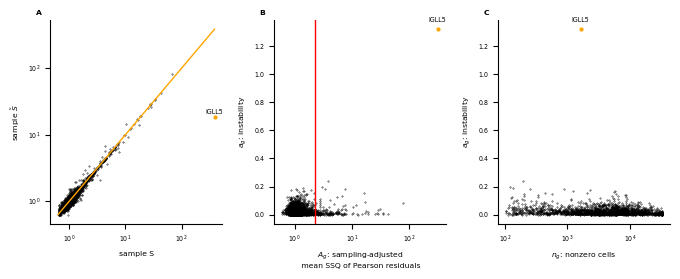

In [7]:
print ( '\n  A_g' )  
df_complementary_stats_Ag = pd.read_pickle ( Ag_complementary_dsn )  
print ( '\n\n df_complementary_stats_Ag' )
print ( '\n', df_complementary_stats_Ag )  

df_stats_Ag = pd.concat ( [ df_nz_cells, df_A_g ], axis=1 ) 
df_stats_Ag = df_stats_Ag.merge ( df_complementary_stats_Ag, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, arr_instability_Ag = plot_tab ( df_stats_Ag, "$A_g$", '$A_g$: sampling-adjusted \n mean SSQ of Pearson residuals',  Ag_plot_dsn, notate=True )     
print ( '\n\n Table ' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)


  L_g


 df_complementary_stats_Lg

                          0          1
ENSEMBL_ID                           
ENSG00000163736  46.790085  46.077720
ENSG00000163220  34.098254  33.776977
ENSG00000087086  32.902598  32.463555
ENSG00000090382  30.894894  30.862072
ENSG00000115523  27.900325  28.609090
...                    ...        ...
ENSG00000198682   0.696335   0.762956
ENSG00000233038   0.681522   0.887475
ENSG00000135549   0.671155   1.625988
ENSG00000155962   0.655804   0.628858
ENSG00000122025   0.654775   0.649210

[10908 rows x 2 columns]


 genes rank_stat_200:  2.678551353285963


 Spearman correlation: number of nonzero cells with instability =  -0.537


 Table 

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        19      1       0        0        0         0      0     20
21-50        1     26       3        0        0         0      0     30
51-100       0      3  

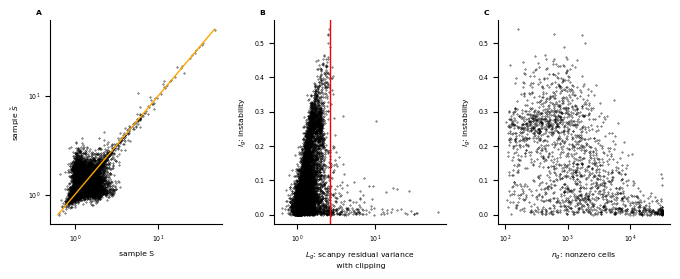

In [8]:
print ( '\n  L_g' )  
df_complementary_stats_Lg = pd.read_pickle ( Lg_complementary_dsn )  
print ( '\n\n df_complementary_stats_Lg' )
print ( '\n', df_complementary_stats_Lg )  

df_stats_Lg = pd.concat ( [ df_nz_cells, df_L_g ], axis=1 ) 
df_stats_Lg = df_stats_Lg.merge ( df_complementary_stats_Lg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, arr_instability_Lg = plot_tab ( df_stats_Lg,  "$L_g$", '$L_g$: scanpy residual variance \n with clipping', Lg_plot_dsn ) 
print ( '\n\n Table ' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)

In [9]:
print ( 'compare distributions: l_g  with  a_g' )

MW_stat, MW_pv = mannwhitneyu( arr_instability_Lg, arr_instability_Ag, alternative='greater' )  
print ( '\n Mann-Whitney one-sided test \n alternative: l_g > a_g' )
print ( ' U-statistic: ', MW_stat,'     p: ', MW_pv )

MW_stat, MW_pv = mannwhitneyu( arr_instability_Lg, arr_instability_Ag, alternative='less' )  
print ( '\n Mann-Whitney one-sided test \n alternative: l_g < a_g' )
print ( ' U-statistic: ', MW_stat,'     p: ', MW_pv )

KS_stat_2_sided, KS_pv_2_sided = ks_2samp( arr_instability_Lg, arr_instability_Ag, alternative='two-sided' )   
print ( '\n KS two-sided test \n alternative: l_g <> a_g' )
print ( ' statistic: ', KS_stat_2_sided,'     p: ', KS_pv_2_sided )
                                    
KS_stat_less, KS_pv_less = ks_2samp( arr_instability_Lg, arr_instability_Ag, alternative='less' )    
print ( '\n KS one-sided test \n alternative: CDF l_g < CDF a_g' )
print ( ' statistic: ', KS_stat_less,'     p: ', KS_pv_less )

KS_stat_greater, KS_pv_greater = ks_2samp( arr_instability_Lg, arr_instability_Ag, alternative='greater' )   
print ( '\n KS one-sided test \n alternative: CDF l_g > CDF a_g' )
print ( ' statistic: ', KS_stat_greater,'     p: ', KS_pv_greater )

compare distributions: l_g  with  a_g

 Mann-Whitney one-sided test 
 alternative: l_g > a_g
 U-statistic:  3026426.0      p:  4.270874347668678e-300

 Mann-Whitney one-sided test 
 alternative: l_g < a_g
 U-statistic:  3026426.0      p:  1.0

 KS two-sided test 
 alternative: l_g <> a_g
 statistic:  0.6229296066252588      p:  0.0

 KS one-sided test 
 alternative: CDF l_g < CDF a_g
 statistic:  0.6229296066252588      p:  2.388e-319

 KS one-sided test 
 alternative: CDF l_g > CDF a_g
 statistic:  0.0005175983436853002      p:  0.9989806594407581



  S_g


 df_complementary_stats_Sg

                         0         1
gene_vector                        
ENSG00000000419  0.878705  1.142931
ENSG00000000457  0.369437  0.467915
ENSG00000000460  0.096608  0.097640
ENSG00000000938  1.499904  1.528135
ENSG00000000971  0.158584  0.174058
...                   ...       ...
ENSG00000273391  0.101806  0.099243
ENSG00000273428  0.404739  0.377022
ENSG00000273445  1.166690  1.006556
ENSG00000273456  0.108065  0.155072
ENSG00000273472  0.352618  0.301178

[10908 rows x 2 columns]


 genes rank_stat_200:  1.9861293651968595


 Spearman correlation: number of nonzero cells with instability =  -0.478


 Table 

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        20      0       0        0        0         0      0     20
21-50        0     29       1        0        0         0      0     30
51-100       0      0      39        9        1 

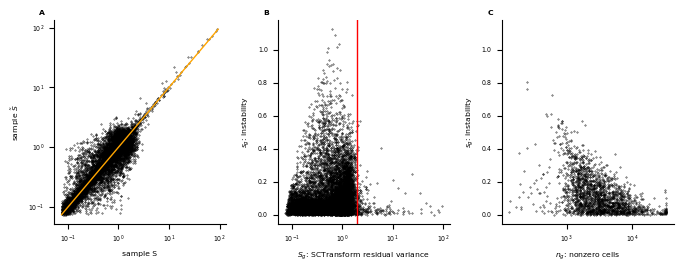

In [10]:
print ( '\n  S_g' )  
df_complementary_stats_Sg = pd.read_pickle ( Sg_complementary_dsn ).set_index ( ['gene_vector'] ).rename( columns={'0':0, '1':1 } )
print ( '\n\n df_complementary_stats_Sg' )
print ( '\n', df_complementary_stats_Sg ) 
 
df_stats_Sg = pd.concat ( [ df_nz_cells, df_S_g ], axis=1 ) 
df_stats_Sg = df_stats_Sg.merge ( df_complementary_stats_Sg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, arr_instability_Sg = plot_tab ( df_stats_Sg,  "$S_g$" , '$S_g$: SCTransform residual variance', Sg_plot_dsn ) 
print ( '\n\n Table ' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)

In [11]:
print ( 'compare distributions: s_g  with  a_g' )

MW_stat, MW_pv = mannwhitneyu( arr_instability_Sg, arr_instability_Ag, alternative='greater' )  
print ( '\n Mann-Whitney one-sided test \n alternative: s_g > a_g' )
print ( ' U-statistic: ', MW_stat,'     p: ', MW_pv )

MW_stat, MW_pv = mannwhitneyu( arr_instability_Sg, arr_instability_Ag, alternative='less' )  
print ( '\n Mann-Whitney one-sided test \n alternative: s_g < a_g' )
print ( ' U-statistic: ', MW_stat,'     p: ', MW_pv )

KS_stat_2_sided, KS_pv_2_sided = ks_2samp( arr_instability_Sg, arr_instability_Ag, alternative='two-sided' )   
print ( '\n KS two-sided test \n alternative: s_g <> a_g' )
print ( ' statistic: ', KS_stat_2_sided,'     p: ', KS_pv_2_sided )
                                    
KS_stat_less, KS_pv_less = ks_2samp( arr_instability_Sg, arr_instability_Ag, alternative='less' )    
print ( '\n KS one-sided test \n alternative: CDF s_g < CDF a_g' )
print ( ' statistic: ', KS_stat_less,'     p: ', KS_pv_less )

KS_stat_greater, KS_pv_greater = ks_2samp( arr_instability_Sg, arr_instability_Ag, alternative='greater' )   
print ( '\n KS one-sided test \n alternative: CDF s_g > CDF a_g' )
print ( ' statistic: ', KS_stat_greater,'     p: ', KS_pv_greater )

compare distributions: s_g  with  a_g

 Mann-Whitney one-sided test 
 alternative: s_g > a_g
 U-statistic:  3236883.0      p:  1.2032869786686072e-294

 Mann-Whitney one-sided test 
 alternative: s_g < a_g
 U-statistic:  3236883.0      p:  1.0

 KS two-sided test 
 alternative: s_g <> a_g
 statistic:  0.5541428571428572      p:  4.310673940312436e-278

 KS one-sided test 
 alternative: CDF s_g < CDF a_g
 statistic:  0.5541428571428572      p:  4.487984230442948e-263

 KS one-sided test 
 alternative: CDF s_g > CDF a_g
 statistic:  0.0005175983436853002      p:  0.9989593775729338
